In [87]:
import pandas as pd
import matplotlib.pyplot as plt

In [88]:
import os
abs_dir = os.getcwd()
rel_dir = os.path.join(abs_dir, '../../data/raw/hospital/AZmariaMiddelares.xlsx')
df = pd.read_excel(rel_dir, sheet_name="Sheet1")

### Sample size

In [89]:
bins = pd.cut(df['Leeftijd'], [0, 10, 20, 30, 40, 50, 60, 70, 80,120])
counts = df.groupby(bins)['Leeftijd'].agg(['count'])
print(counts)

           count
Leeftijd        
(0, 10]        0
(10, 20]       4
(20, 30]       4
(30, 40]       8
(40, 50]      44
(50, 60]      44
(60, 70]      77
(70, 80]     145
(80, 120]    213


In [66]:
ICU_alive = df.loc[(df['Bestemming na ontslag'] != 'Overleden') & ( df['Afdeling'] == 'IZ')]['Ligduur']
ICU_dead = df.loc[(df['Bestemming na ontslag'] == 'Overleden') & ( df['Afdeling'] == 'IZ')]['Ligduur']
print(ICU_alive.mean(),len(ICU_alive),ICU_dead.mean(),len(ICU_dead))

9.940549793103447 29 21.007198736842106 19


(array([3., 4., 2., 2., 3., 2., 0., 0., 1., 2.]),
 array([ 1.294444 ,  6.6977074, 12.1009708, 17.5042342, 22.9074976,
        28.310761 , 33.7140244, 39.1172878, 44.5205512, 49.9238146,
        55.327078 ]),
 <a list of 10 Patch objects>)

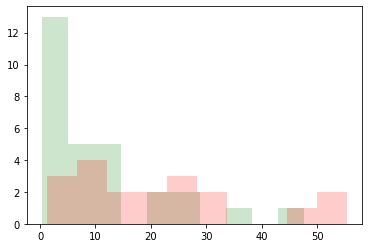

In [71]:
plt.hist(ICU_alive,alpha=0.2,color='green')
plt.hist(ICU_dead,alpha=0.2,color='red')

In [68]:
Cohort_alive = df.loc[(df['Bestemming na ontslag'] != 'Overleden') & ( (df['Afdeling'] == 'Cohort-afdeling D501')|(df['Afdeling'] == 'Cohort-afdeling D601'))]['Ligduur']
Cohort_dead = df.loc[(df['Bestemming na ontslag'] == 'Overleden') & ( (df['Afdeling'] == 'Cohort-afdeling D501')|(df['Afdeling'] == 'Cohort-afdeling D601'))]['Ligduur']
print(Cohort_alive.mean(),len(Cohort_alive),Cohort_dead.mean(),len(Cohort_dead))

6.944776248062016 129 4.70486 43


(array([14., 11.,  4.,  5.,  4.,  1.,  0.,  1.,  1.,  2.]),
 array([ 0.409721,  2.086457,  3.763193,  5.439929,  7.116665,  8.793401,
        10.470137, 12.146873, 13.823609, 15.500345, 17.177081]),
 <a list of 10 Patch objects>)

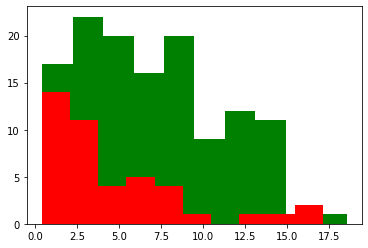

In [69]:
plt.hist(Cohort_alive,color='green')
plt.hist(Cohort_dead,color='red')

In [154]:
patients_dict={}

In [179]:
id_group=df.groupby(['Opnamenummer'])
for g_idx, group in id_group:
    # add patient ID
    patients_dict.update({g_idx: {}})
    # add patient age
    patients_dict[g_idx].update({'Age':group['Leeftijd'].values[0]})
    # add patient sex
    if group['Geslacht'].values[0] == 'Man':
        patients_dict[g_idx].update({'Sex': 'M'})
    else:
        patients_dict[g_idx].update({'Sex': 'F'})
    # add patient recovered or dead
    if group['Bestemming na ontslag'].values[0] != 'Overleden':
        patients_dict[g_idx].update({'Status': 'R'})
    else:
        patients_dict[g_idx].update({'Status': 'D'})
    # add patients wards as list, neglect emergency room and buffer
    wards=[]
    lengths=[]
    for r_idx, row in group.iterrows(): 
        if (group['Afdeling'][r_idx] != 'Spoed' and group['Afdeling'][r_idx] != 'Bufferafdeling'):
            wards.append(group['Afdeling'][r_idx])
            lengths.append(group['Ligduur'][r_idx])
    patients_dict[g_idx].update({'Wards': wards[::-1]})
    patients_dict[g_idx].update({'Lenghts': lengths[::-1]})

In [180]:
print(patients_dict)

{2016322226: {'Age': 73, 'Sex': 'M', 'Status': 'R', 'Wards': ['IZ', 'Cohort-afdeling D501'], 'Lenghts': [2.92361, 12.977777]}, 2022936111: {'Age': 84, 'Sex': 'F', 'Status': 'R', 'Wards': ['Cohort-afdeling D501'], 'Lenghts': [18.568744]}, 2023253076: {'Age': 88, 'Sex': 'F', 'Status': 'R', 'Wards': ['Cohort-afdeling D601'], 'Lenghts': [14.11736]}, 2024158715: {'Age': 79, 'Sex': 'M', 'Status': 'D', 'Wards': ['Cohort-afdeling D501'], 'Lenghts': [2.90972]}, 2024849738: {'Age': 63, 'Sex': 'M', 'Status': 'R', 'Wards': ['IZ', 'Cohort-afdeling D501'], 'Lenghts': [0.729166, 8.968749]}, 2025024439: {'Age': 89, 'Sex': 'M', 'Status': 'D', 'Wards': ['IZ'], 'Lenghts': [8.790972]}, 2025214904: {'Age': 43, 'Sex': 'M', 'Status': 'R', 'Wards': ['Cohort-afdeling D501'], 'Lenghts': [4.997222]}, 2025250973: {'Age': 81, 'Sex': 'F', 'Status': 'R', 'Wards': ['IZ', 'Cohort-afdeling D501'], 'Lenghts': [4.020832, 11.008332]}, 2025272191: {'Age': 81, 'Sex': 'F', 'Status': 'R', 'Wards': ['Cohort-afdeling D601', 'Co

In [182]:
age = []
age_R = []
age_D = []
IZ_R = []

for ID in patients_dict:
    age.append(patients_dict[ID]['Age'])
    if patients_dict[ID]['Status'] == 'R':
        age_R.append(patients_dict[ID]['Age'])
    else:
        age_D.append(patients_dict[ID]['Age'])
        

(array([ 2.,  1.,  4.,  3.,  9., 20., 18., 48., 54., 41.]),
 array([ 0. ,  9.7, 19.4, 29.1, 38.8, 48.5, 58.2, 67.9, 77.6, 87.3, 97. ]),
 <a list of 10 Patch objects>)

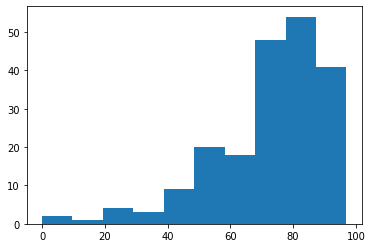

In [148]:
plt.hist(age)

(array([ 3.,  0.,  0.,  1.,  7.,  4.,  8.,  7., 12.,  7.]),
 array([49. , 53.8, 58.6, 63.4, 68.2, 73. , 77.8, 82.6, 87.4, 92.2, 97. ]),
 <a list of 10 Patch objects>)

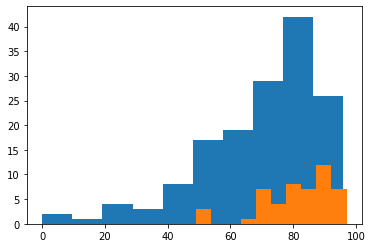

In [152]:
plt.hist(age_R)
plt.hist(age_D)